# Давайте на примере рассмотрим, как можно построить систему рекомендаций на основе популярности.

Мы будем работать с набором данных Movie Lens. Он содержит идентификаторы для каждого фильма и пользователя, который его смотрел, а также оценку, которую пользователь поставил фильму. В датасете представлено 25 000 095 оценок фильмов от 162 541 пользователя со шкалой оценок от 0.5 до 5.0.

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

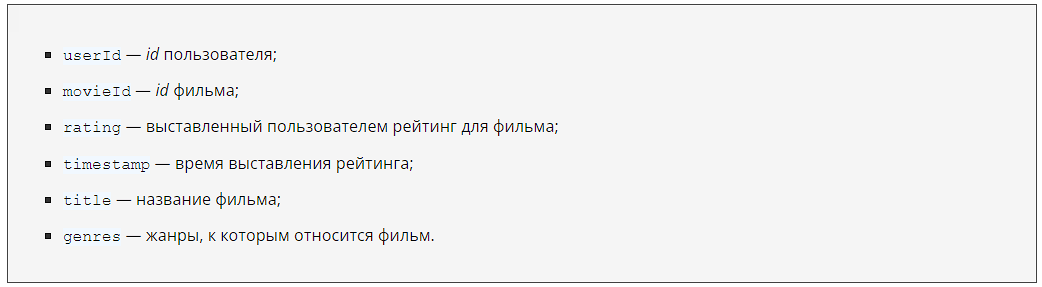

In [3]:
movies = pd.read_csv('data/movie.zip')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [4]:
ratings = pd.read_csv('data/dst-3.0_mathml_14_5_rating.zip')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [5]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [6]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


Связываю таблицы, добавляю в таблицу рейтингов title, genres

In [7]:
full_ratings = ratings.merge(right=movies, on='movieId', how='left')

### Задание 5.1
Подсчитайте, сколько раз каждый фильм встречается в наборе данных.
 
Отметьте среди перечисленных ниже фильмов те, что встречаются в топ-5 по популярности.

In [10]:
movies_freq = full_ratings.groupby(by='title')['title'].size().to_frame()
movies_freq.columns = ['freq']
movies_freq.sort_values(by='freq', ascending=False, inplace=True)
top_five = movies_freq.iloc[:5, ]
top_five

,freq
title,
Pulp Fiction (1994),67310
Forrest Gump (1994),66172
"Shawshank Redemption, The (1994)",63366
"Silence of the Lambs, The (1991)",63299
Jurassic Park (1993),59715


### Задание 5.2
Отлично, мы нашли самые востребованные фильмы. Однако если фильм посмотрело много людей, это ещё не значит, что он им понравился. Чтобы понять, как зритель на самом деле относится к фильму, нужны более чёткие данные. К счастью, в наборе данных Movie Lens есть оценки каждого из зрителей.

- Найдите средний рейтинг для каждого из фильмов.
- Найдите фильмы с наивысшим средним рейтингом.
- Введите в качестве ответа фильм, занимающий последнее место среди фильмов с наивысшим рейтингом, если предварительно отсортировать их по алфавитному порядку.

Впишите только название фильма, без кавычек и без года выхода на экран.

Если название фильма состоит из двух и более слов, между отдельными словами должен быть только один пробел.

In [13]:
movies_rating = full_ratings.groupby(by='title')['rating'].mean().to_frame()
movies_rating.columns = ['Avg_rating']
movies_rating.sort_values(by='Avg_rating', ascending=False, inplace=True)
movies_rating

,Avg_rating
title,
Small Roads (2011),5.0
Divorce (1945),5.0
The Beautiful Story (1992),5.0
Into the Middle of Nowhere (2010),5.0
The Sea That Thinks (2000),5.0
...,...
I Dream Too Much (1935),0.5
Cameron's Closet (1988),0.5
Double Trouble (1992),0.5


In [20]:
movies_rating[movies_rating['Avg_rating'] == 5].sort_values(by='title')

,Avg_rating
title,
1971 (2014),5.0
A Blank on the Map (1971),5.0
A Gun for Jennifer (1997),5.0
A Night for Dying Tigers (2010),5.0
Abendland (2011),5.0
...,...
Welcome to Australia (1999),5.0
When I Walk (2013),5.0
Who Killed Vincent Chin? (1987),5.0


### Задание 5.3
В двух предыдущих заданиях вы использовали два самых простых метода для создания неперсонализированных рекомендаций. Однако у них обоих есть свои недостатки: поиск наиболее часто просматриваемых фильмов не учитывает того, насколько фильм нравится аудитории, а поиск среднего рейтинга может вывести в рекомендуемые фильмы малоизвестные специфические картины с одной-двумя оценками.

Чтобы решить эти проблемы, объединим два подхода и будем искать средний рейтинг только для фильмов, которые были оценены более 50 раз.

Сколько таких фильмов?

In [29]:
movies_rating_and_freq = full_ratings.groupby(by='title')['rating'].agg(['size', 'mean'])
movies_rating_and_freq.columns = ['Freq', 'Avg_rating']
movies_rating_and_freq[movies_rating_and_freq['Freq'] > 50].sort_values(
    by='Avg_rating', ascending=False)

,Freq,Avg_rating
title,,
"Shawshank Redemption, The (1994)",63366,4.446990
"Godfather, The (1972)",41355,4.364732
"Usual Suspects, The (1995)",47006,4.334372
Schindler's List (1993),50054,4.310175
"Godfather: Part II, The (1974)",27398,4.275641
...,...,...
Barney's Great Adventure (1998),419,1.163484
Glitter (2001),685,1.124088
Bratz: The Movie (2007),180,1.105556
